In [1]:
from torch import nn
import torch
from torch import tensor 
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.metrics import roc_auc_score

train= pd.read_csv('output.csv')
#df = pd.read_csv('./data/my.nih.norm.csv')
#df1 = pd.read_csv('./data/abcd_tbss01.csv')


In [2]:
data_all=train[train['HSE gap'].isnull() ==False]

In [3]:

dataset=data_all.fillna(0).reset_index(drop=True)

In [4]:
dataset

,Material,ICSD number,GGA gap,HSE gap,Atomic mass,Atomic no,Atomic orbitals_1s,Atomic orbitals_2s,Atomic orbitals_2p,Atomic orbitals_3s,...,Min oxidation state,Ionic radii hs_2,Ionic radii hs_3,Ionic radii hs_4,Ionic radii ls_2,Ionic radii ls_3,Ionic radii ls_4,Ionic radii ls_5,Ionic radii ls_6,Ionic radii ls_7
0,S,38263,1.975665,3.067626,32.065000,16.0,-87.789937,-7.699940,-5.751257,-0.630912,...,0.0,0.000,0.00,0.00,0.00,0.000,0.0,0.0,0.0,0.0
1,Se,86375,1.479159,2.299414,78.960000,34.0,-451.300258,-57.311948,-51.514388,-7.547186,...,0.0,0.000,0.00,0.00,0.00,0.000,0.0,0.0,0.0,0.0
2,C,193439,0,0.000000,12.010700,6.0,-9.947718,-0.500866,-0.199186,0.000000,...,0.0,0.000,0.00,0.00,0.00,0.000,0.0,0.0,0.0,0.0
3,C,157074,0.101161,0.112731,12.010700,6.0,-9.947718,-0.500866,-0.199186,0.000000,...,0.0,0.000,0.00,0.00,0.00,0.000,0.0,0.0,0.0,0.0
4,C,20351,3.011296,4.134729,12.010700,6.0,-9.947718,-0.500866,-0.199186,0.000000,...,0.0,0.000,0.00,0.00,0.00,0.000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,Co1F1H4Na1O6S1,169111,3.202057,4.974672,58.933195,27.0,-275.616639,-32.379758,-28.152095,-3.651812,...,0.0,0.885,0.75,0.67,0.79,0.685,0.0,0.0,0.0,0.0
11996,C2H6K1N4O4P1,424131,5.238256,6.872532,12.010700,6.0,-9.947718,-0.500866,-0.199186,0.000000,...,0.0,0.000,0.00,0.00,0.00,0.000,0.0,0.0,0.0,0.0
11997,B2Be2Ca1F1K1O6,183886,5.256318,7.025251,10.811000,5.0,-6.564347,-0.344701,-0.136603,0.000000,...,0.0,0.000,0.00,0.00,0.00,0.000,0.0,0.0,0.0,0.0
11998,C8Cr1H12N2O2S2,250698,1.989884,3.025600,12.010700,6.0,-9.947718,-0.500866,-0.199186,0.000000,...,0.0,0.000,0.00,0.00,0.00,0.000,0.0,0.0,0.0,0.0


In [5]:
HSE_class=[]
for i in dataset['HSE gap'] :
    if i == 0:
        HSE_class.append(0)
    elif i!= 0:
        HSE_class.append(1)

In [6]:
dataset['HSE_class']= HSE_class

In [7]:



if "Set" not in dataset.columns:
    dataset["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(dataset.shape[0],))

train_indices = dataset[dataset.Set=="train"].index
valid_indices = dataset[dataset.Set=="valid"].index
test_indices = dataset[dataset.Set=="test"].index

In [8]:
target = 'HSE_class'
unused_feat = ['Material', 'Set', 'GGA gap', 'HSE gap']
features = [ col for col in train.columns if col not in unused_feat + [target]] 

In [9]:
X_train = dataset[features].values[train_indices]
y_train = dataset[target].values[train_indices]
X_valid = dataset[features].values[valid_indices]
y_valid = dataset[target].values[valid_indices]
X_test = dataset[features].values[test_indices]
y_test = dataset[target].values[test_indices]

print("X_train.shape: ", X_train.shape)
print("y_train.shape: ",y_train.shape)
print("X_valid.shape: ", X_valid.shape)
print("y_valid.shape: ",y_valid.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ",y_test.shape)

X_train.shape:  (9564, 114)
y_train.shape:  (9564,)
X_valid.shape:  (1246, 114)
y_valid.shape:  (1246,)
X_test.shape:  (1190, 114)
y_test.shape:  (1190,)


In [ ]:
# Augmented
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm
# Store maximum auc
max_auc = 0
# Store maximum hypterparameter set
max_hy = []
# define hyperparameter space
n_ = [4,8,16]
lr_ = [2e-2, 1e-2, 2e-3]
w_ = [0.01, 0.001]
g_ = [0.95, 0.99, 0.9]
ss_ = [10, 20, 30]
all_ = [n_, lr_, w_, g_, ss_]
h_space = [s for s in itertools.product(*all_)]
# Start training


for hy in tqdm(h_space):
    clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                           )
    clf.fit(X_train, y_train, X_valid, y_valid, patience=50, batch_size=256, max_epochs=200)
    preds_acc = clf.predict(X_test)
    preds_prob = clf.predict_proba(X_test)
    test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=y_test)
    test_acc = accuracy_score(preds_acc, y_test)
    print("FINAL TEST SCORE", test_auc, test_acc)
    if test_auc>max_auc:
        max_hy = hy
        max_auc = test_auc


In [11]:
import torch
import itertools
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from tqdm.notebook import tqdm

hy = (4, 0.02, 0.01, 0.99, 10)
clf = TabNetClassifier(n_a = hy[0],
                           n_d = hy[0],
                           optimizer_params = dict(lr=hy[1], weight_decay=hy[2]),
                           scheduler_params={"step_size":hy[4], "gamma":hy[3]},
                           scheduler_fn=torch.optim.lr_scheduler.StepLR,
                           verbose=0
                           )
clf.fit(X_train, y_train, X_valid, y_valid, patience=50, batch_size=256, max_epochs=200)
preds_acc = clf.predict(X_test)
preds_prob = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds_prob[:,1], y_true=y_test)
test_acc = accuracy_score(preds_acc, y_test)
print("max_hy = " ,hy)
print("FINAL TEST SCORE", test_auc, test_acc)
    

Device used : cuda
max_hy =  (4, 0.02, 0.01, 0.99, 10)
FINAL TEST SCORE 0.6982244691607684 0.9033613445378151


Text(0, 0.5, 'Loss')

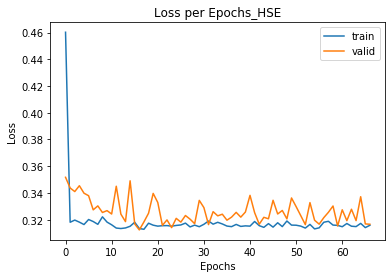

In [32]:

plt.plot(clf.history['train']['loss'], label='train')
plt.plot(clf.history['valid']['loss'], label='valid')
plt.legend()

plt.title('Loss per Epochs_HSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')



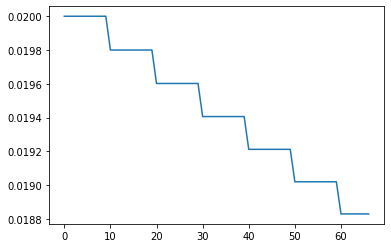

In [20]:
plt.plot(clf.history['train']['lr'])


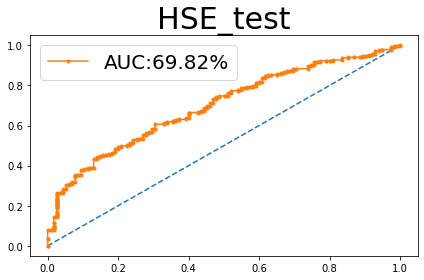

In [21]:
def rocvis(true , prob , label ) :
    from sklearn.metrics import roc_curve
    if type(true[0]) == str :
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        true = le.fit_transform(true)
    else :
        pass
    fpr, tpr, thresholds = roc_curve(true, prob)
    plt.plot(fpr, tpr, marker='.', label = label  )

target_name = 'HSE'
plt.plot([0, 1], [0, 1], linestyle='--')
rocvis(y_test , preds_prob[:,1] , f"AUC:{round(test_auc*100, 2)}%")

plt.legend(fontsize = 20)
plt.title(f'{target_name}_test', fontsize= 30)
plt.tight_layout()
plt.savefig(f'{target_name}_ROC.png')
plt.show()        


In [24]:
data_null=train[train['HSE gap'].isnull() ==True]

In [25]:
data_null.to_csv('nullDF.csv')

In [26]:
X_test_null=data_null.fillna(0).reset_index(drop=True)[features].values

In [27]:
X_test_null

array([[1.68757000e+05, 4.00780000e+01, 2.00000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.66680000e+04, 5.86934000e+01, 2.80000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.68759000e+05, 4.00780000e+01, 2.00000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.80403000e+05, 1.38905470e+02, 5.70000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.14539000e+05, 1.96966569e+02, 7.90000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.80491000e+05, 3.54530000e+01, 1.70000000e+01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [28]:
preds_acc_null = clf.predict(X_test_null)
preds_prob_null = clf.predict_proba(X_test_null)

In [29]:
pd.DataFrame (preds_acc_null).to_csv('Null_classify.csv')


In [30]:
pd.DataFrame(preds_prob_null).to_csv('Null_prop.csv')

In [31]:
important_features.reset_index(drop=True).to_csv("data_all_HSE.csv")

NameError: name 'important_features' is not defined